Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from pycaret.classification import *

import tensorflow.keras as keras

import warnings
warnings.filterwarnings('ignore')

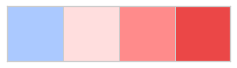

In [2]:
# Set Color Pallete
custom_colors = ["#ABC9FF", "#FFDEDE", "#FF8B8B", "#EB4747"]
sns.palplot(sns.color_palette(custom_colors))

## Modeling

Sampling Data for AutoML model recommendation with PyCaret

In [3]:
train_normal = pd.read_csv("train_normal.csv")
train_fraud = pd.read_csv("train_fraud.csv")
test_normal = pd.read_csv("test_normal.csv")
test_fraud = pd.read_csv("test_fraud.csv")

train = pd.concat([train_normal, train_fraud])
test = pd.concat([test_normal, test_fraud])

train_sample = pd.concat([train_normal.sample(frac=0.02), train_fraud.sample(frac=0.02)])
test_sample = pd.concat([test_normal.sample(frac=0.02), test_fraud.sample(frac=0.02)])

train_sample.shape, test_sample.shape

((25933, 12), (11114, 12))

In [4]:
exp = setup(data=train_sample, test_data=test_sample, target = "is_fraud", fold=10, normalize=True)
exp

,Description,Value
0,Session id,2114
1,Target,is_fraud
2,Target type,Binary
3,Original data shape,"(37055, 12)"
4,Transformed data shape,"(37055, 25)"
5,Transformed train set shape,"(25939, 25)"
6,Transformed test set shape,"(11116, 25)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,2


In [5]:
best_model = compare_models(n_select=3, sort='f1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9967,0.9582,0.5950,0.8223,0.6821,0.6804,0.6936,0.0940
xgboost,Extreme Gradient Boosting,0.9968,0.9590,0.5875,0.8251,0.6802,0.6786,0.6916,0.3840
dt,Decision Tree Classifier,0.9960,0.8257,0.6533,0.6712,0.6559,0.6539,0.6571,0.0580
gbc,Gradient Boosting Classifier,0.9963,0.8453,0.5546,0.7712,0.6283,0.6265,0.6427,0.4020
rf,Random Forest Classifier,0.9965,0.9488,0.4504,0.9234,0.5967,0.5952,0.6382,0.2690
et,Extra Trees Classifier,0.9961,0.9256,0.3717,0.9231,0.5248,0.5232,0.5809,0.2230
ada,Ada Boost Classifier,0.9948,0.9343,0.2875,0.6288,0.3892,0.3870,0.4196,0.1960
lda,Linear Discriminant Analysis,0.9920,0.8975,0.4054,0.3662,0.3791,0.3752,0.3785,0.0670
nb,Naive Bayes,0.9816,0.8138,0.3983,0.1505,0.2135,0.2067,0.2341,0.0520
knn,K Neighbors Classifier,0.9939,0.6863,0.0987,0.5783,0.1575,0.1558,0.2232,0.5500


In [6]:
evaluate_model(best_model[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Preprocessing pipeline by PyCarret is unoptimized <br>
<h4>Create new preprocessor

In [4]:
cols = ['category', 'amt', 'gender', 'city_pop', 'lat', 'long', 
        'day_of_week', 'late_hour', 'early_hour', 'elderly', 'young']

X_train = train[cols]
y_train = train['is_fraud']
X_test = test[cols]
y_test = test['is_fraud']

In [5]:
numeric_features = ["amt", "lat", "long", "city_pop"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())
    ]
)

categorical_features = ["category", "gender", "day_of_week", "late_hour", "early_hour", "elderly", "young"]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['amt', 'lat', 'long', 'city_pop']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['category', 'gender', 'day_of_week',
                                  'late_hour', 'early_hour', 'elderly',
                                  'young'])])

In [6]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train, y_train).toarray(), index=X_train.index, columns=preprocessor.get_feature_names_out(), dtype='float32')
X_test = pd.DataFrame(preprocessor.transform(X_test).toarray(), columns=preprocessor.get_feature_names_out(), dtype='float32')

# import joblib
# joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

### Basic ML Algorithm

In [74]:
def plot_cm(labels, predictions, p=0.5, clf=''):
    # Plot Confusion Matrix
    predictions = predictions > p
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=custom_colors, fmt="d")
    plt.title('Confusion matrix '+str(clf))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print(classification_report(labels, predictions))

#### Light Gradient Boosting

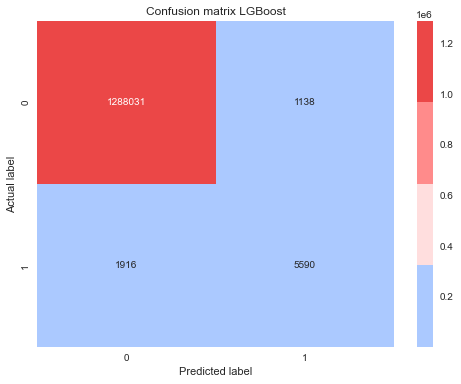

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.83      0.74      0.79      7506

    accuracy                           1.00   1296675
   macro avg       0.91      0.87      0.89   1296675
weighted avg       1.00      1.00      1.00   1296675



In [ ]:
from lightgbm import LGBMClassifier

lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train, y_train)
y_train_pred = lgb_clf.predict(X_train)

plot_cm(y_train, y_train_pred, clf='LGBoost')

#### XGBoost

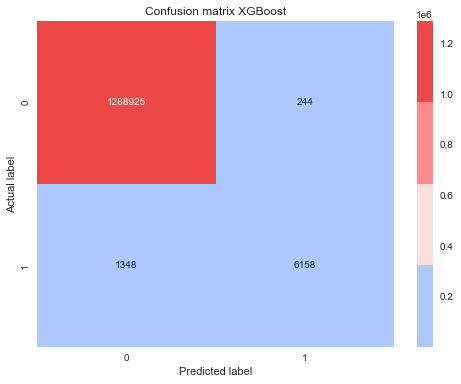

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.96      0.82      0.89      7506

    accuracy                           1.00   1296675
   macro avg       0.98      0.91      0.94   1296675
weighted avg       1.00      1.00      1.00   1296675



In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)
y_train_pred = xgb_clf.predict(X_train)

plot_cm(y_train, y_train_pred, clf='XGBoost')

#### Random Forest

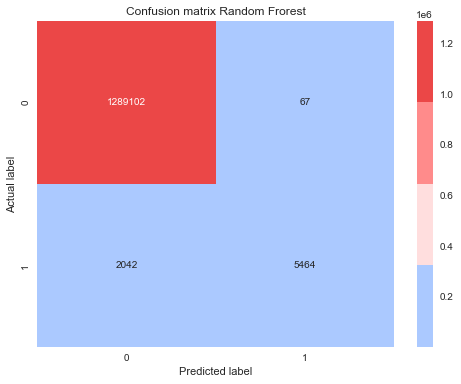

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.99      0.73      0.84      7506

    accuracy                           1.00   1296675
   macro avg       0.99      0.86      0.92   1296675
weighted avg       1.00      1.00      1.00   1296675



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=20, max_depth=15)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)

plot_cm(y_train, y_train_pred, clf='Random Frorest')

#### Quadratic Discriminant Analysis

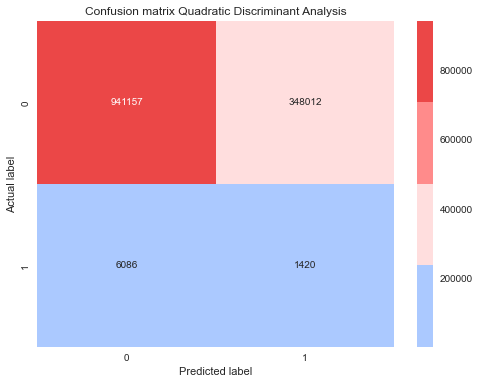

              precision    recall  f1-score   support

           0       0.99      0.73      0.84   1289169
           1       0.00      0.19      0.01      7506

    accuracy                           0.73   1296675
   macro avg       0.50      0.46      0.42   1296675
weighted avg       0.99      0.73      0.84   1296675



In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_clf = QuadraticDiscriminantAnalysis()

qda_clf.fit(X_train, y_train)
y_train_pred = qda_clf.predict(X_train)

plot_cm(y_train, y_train_pred, clf='Quadratic Discriminant Analysis')

### Deep Learning models with Keras

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05)

y_val.value_counts()

0    56505
1      306
Name: is_fraud, dtype: int64

Define some metrics

In [99]:
METRICS = [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

def plot_metrics(history):
    metrics = ['precision', 'recall', 'auc', 'prc']
    plt.figure(figsize=(14,8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=custom_colors[3], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=custom_colors[2], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

#### Shallow Neural Net

In [58]:
shallow_nn = keras.models.Sequential([
      keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1], )),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1, activation='sigmoid')
])

checkpoint = keras.callbacks.ModelCheckpoint('shallow_nn', monitor='recall', save_best_only=True)

shallow_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=METRICS)

shallow_nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 248       
                                                                 
 batch_normalization_8 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 273
Non-trainable params: 16
_________________________________________________________________


INFO:tensorflow:Assets written to: shallow_nn\assets


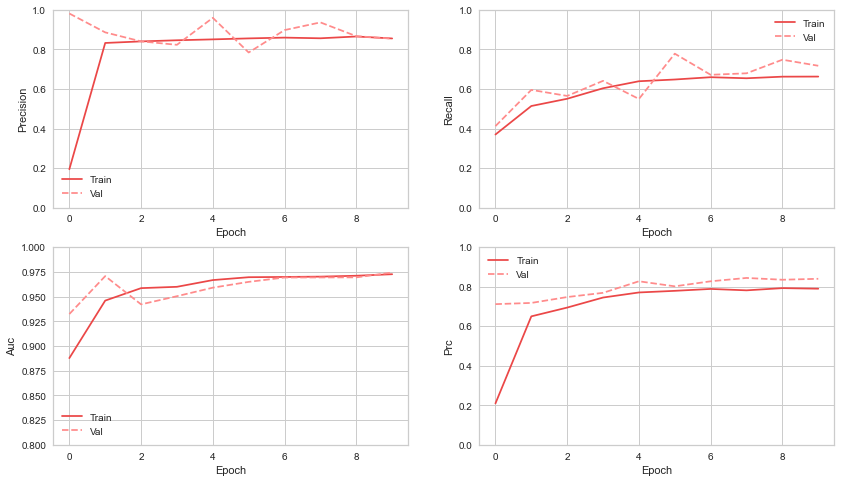

In [60]:
shallow_hist = shallow_nn.fit(X_train, y_train, 
                              validation_data=(X_val, y_val), 
                              epochs=10, 
                              batch_size=2048, 
                              callbacks=checkpoint,
                              verbose=0)

plot_metrics(shallow_hist)

584/584 [==============================] - 2s 3ms/step


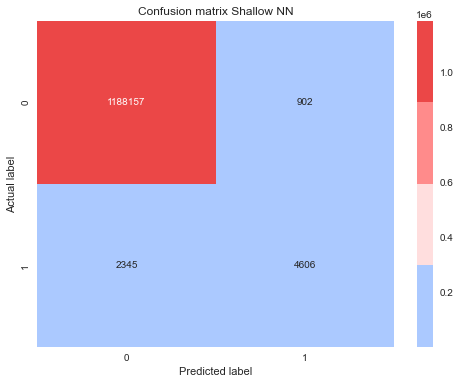

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1189059
           1       0.84      0.66      0.74      6951

    accuracy                           1.00   1196010
   macro avg       0.92      0.83      0.87   1196010
weighted avg       1.00      1.00      1.00   1196010



In [63]:
y_train_pred = shallow_nn.predict(X_train, batch_size=2048) > 0.5
plot_cm(y_train, y_train_pred, clf='Shallow NN')

#### Bigger Neural Net

In [64]:
big_nn = keras.models.Sequential([
      keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1], )),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1, activation='sigmoid')
])

checkpoint = keras.callbacks.ModelCheckpoint('big_nn', monitor='recall', save_best_only=True)

big_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
            loss='binary_crossentropy',
            metrics=METRICS)

big_nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1984      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,721
Trainable params: 6,465
Non-traina

INFO:tensorflow:Assets written to: big_nn\assets


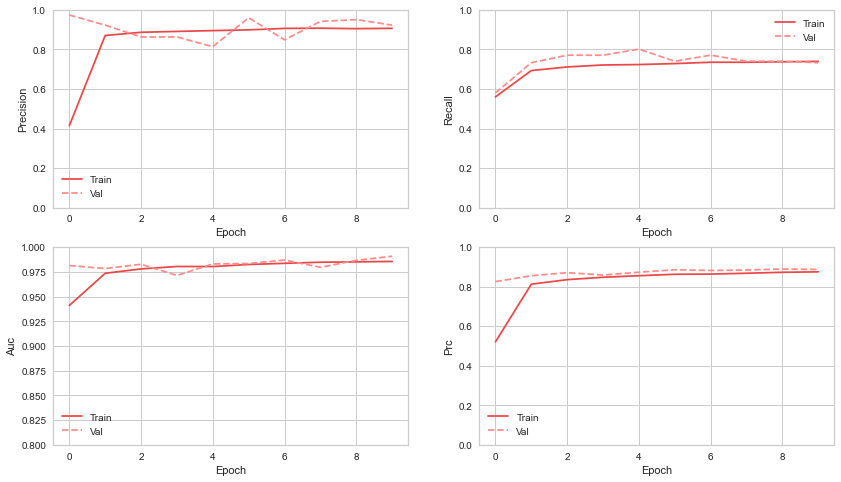

In [65]:
big_hist = big_nn.fit(X_train, y_train, 
                      validation_data=(X_val, y_val), 
                      epochs=10, 
                      batch_size=2048, 
                      callbacks=checkpoint,
                      verbose=0)

plot_metrics(big_hist)

584/584 [==============================] - 1s 2ms/step


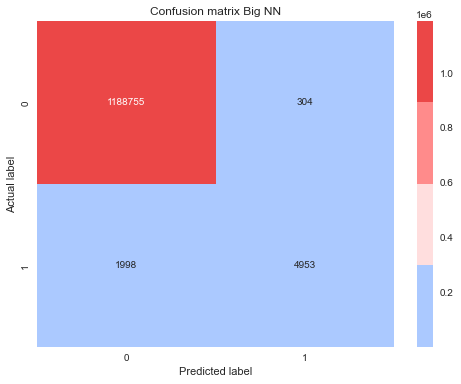

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1189059
           1       0.94      0.71      0.81      6951

    accuracy                           1.00   1196010
   macro avg       0.97      0.86      0.91   1196010
weighted avg       1.00      1.00      1.00   1196010



In [66]:
y_train_pred = big_nn.predict(X_train, batch_size=2048) > 0.5
plot_cm(y_train, y_train_pred, clf='Big NN')

#### Deeper Neural Net

In [100]:
deep_nn = keras.models.Sequential([
      keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1], )),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1, activation='sigmoid')
])

checkpoint = keras.callbacks.ModelCheckpoint('deep_nn', monitor='recall', save_best_only=True)

deep_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=METRICS)

deep_nn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 16)                496       
                                                                 
 batch_normalization_26 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_27 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_28 (Bat  (None, 16)             

INFO:tensorflow:Assets written to: deep_nn\assets


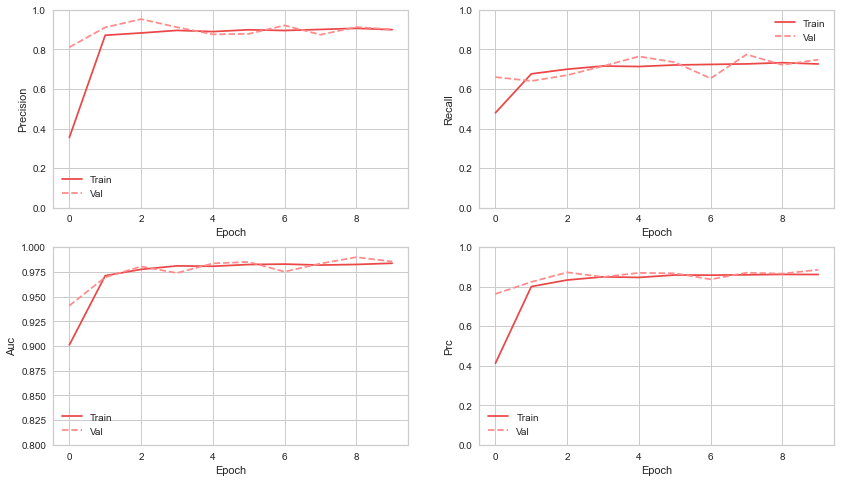

In [101]:
deep_hist = deep_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=10, 
                        batch_size=2048, 
                        callbacks=checkpoint,
                        verbose=0)

plot_metrics(deep_hist)

528/528 [==============================] - 2s 3ms/step


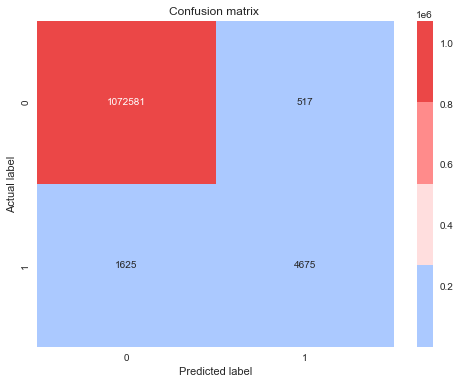

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1073098
           1       0.90      0.74      0.81      6300

    accuracy                           1.00   1079398
   macro avg       0.95      0.87      0.91   1079398
weighted avg       1.00      1.00      1.00   1079398



In [102]:
y_train_pred = deep_nn.predict(X_train, batch_size=2048)
plot_cm(y_train, y_train_pred)

## Tuning Models

### Deep Neural Net Tuning

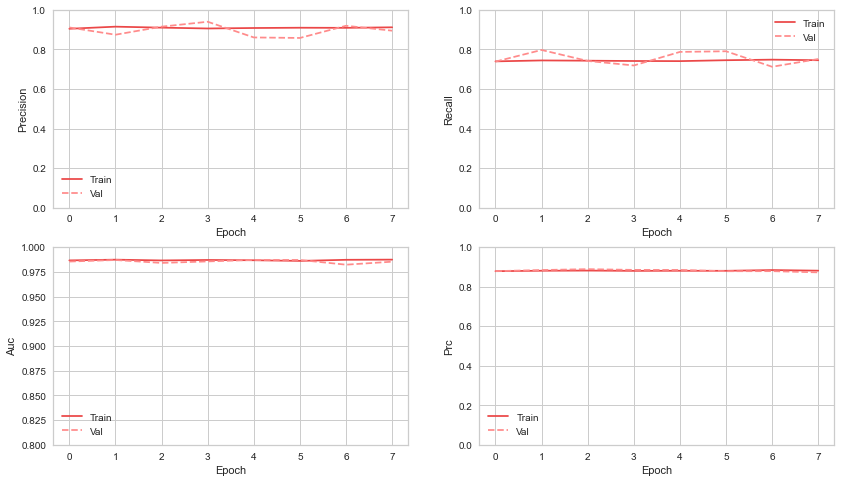

In [104]:
deep_nn.optimizer.learning_rate=0.005

deep_hist = deep_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=50, 
                        batch_size=2048, 
                        callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                        verbose=0)

plot_metrics(deep_hist)

272/272 [==============================] - 3s 10ms/step
----Train Result----


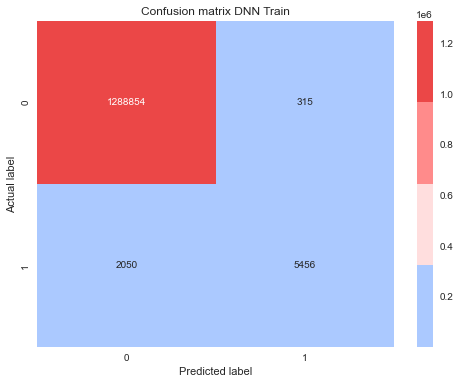

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.95      0.73      0.82      7506

    accuracy                           1.00   1296675
   macro avg       0.97      0.86      0.91   1296675
weighted avg       1.00      1.00      1.00   1296675

----Test Result----


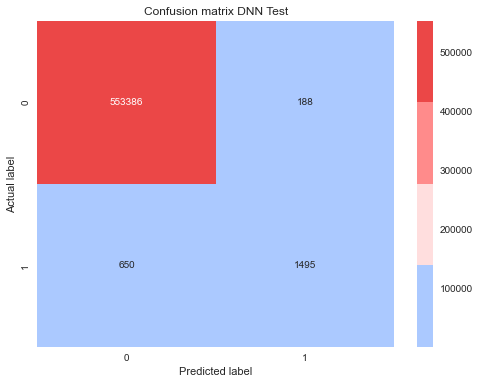

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.89      0.70      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.85      0.89    555719
weighted avg       1.00      1.00      1.00    555719



In [106]:
# from keras.wrappers.scikit_learn import KerasClassifier

# X_train = train[cols]
# y_train = train['is_fraud']
# X_test = test[cols]
# y_test = test['is_fraud']

# def function_wrapper():
#     return deep_nn

# deep_nn_clf = KerasClassifier(function_wrapper, batch_size=2048)

# dnn_pipe = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('clf', deep_nn_clf)
# ])

# dnn_pipe.fit(X_train, y_train)
# y_train_pred = dnn_pipe.predict(X_train, batch_size=2048)
# y_test_pred = dnn_pipe.predict(X_test, batch_size=2048)

y_train_pred = deep_nn.predict(X_train, batch_size=2048)
y_test_pred  = deep_nn.predict(X_test, batch_size=2048)

print("----Train Result----")
plot_cm(y_train, y_train_pred, clf="DNN Train")
print("----Test Result----")
plot_cm(y_test, y_test_pred, clf="DNN Test")

### XGBoost Tuning

In [111]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier())
])

params={
    'clf__n_estimators':[50, 100],
    'clf__max_depth':[None, 5]
}

grid_pipe = GridSearchCV(pipe, param_grid=params, cv=3, verbose=1)
grid_pipe.fit(X_train, y_train)

grid_pipe.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


{'clf__max_depth': 5, 'clf__n_estimators': 50}

----Training Result----


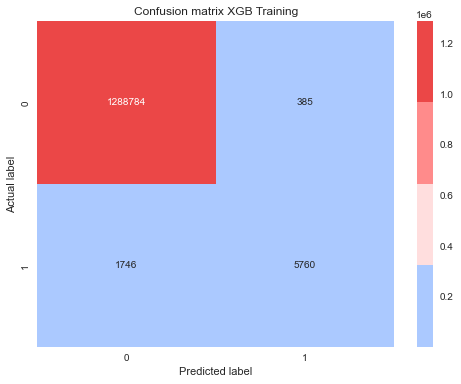

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.94      0.77      0.84      7506

    accuracy                           1.00   1296675
   macro avg       0.97      0.88      0.92   1296675
weighted avg       1.00      1.00      1.00   1296675

----Testing Result----


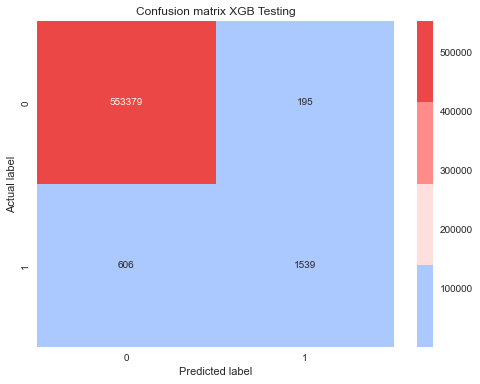

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.89      0.72      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719



In [112]:
y_train_pred = grid_pipe.predict(X_train)
y_test_pred = grid_pipe.predict(X_test)

print("----Training Result----")
plot_cm(y_train, y_train_pred, clf='XGB Training')
print("----Testing Result----")
plot_cm(y_test, y_test_pred, clf='XGB Testing')

In [125]:
import joblib

joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(grid_pipe, "xgb_pipe.pkl")
deep_nn.save("deep_nn")

INFO:tensorflow:Assets written to: deep_nn\assets
